In [12]:
from lib.network import DepthNet
from lib.loss_depth import LossDepth
from lib.utils import setup_logger, im_convert, depth_to_img
from datasets.linemod.dataset import DepthDataset
import torch
import os
from torch import optim
import numpy as np
import time
from torch.autograd import Variable
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore") 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
dataset_root = "./datasets/linemod/Linemod_preprocessed"
log_dir = 'experiments/logs/depth_prediction'
outf = 'trained_models/depth_prediction'

dataset = DepthDataset('train', dataset_root)
dataloader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=1, 
                                         shuffle=True, 
                                         num_workers=1)

Object 6 buffer loaded
Object 8 buffer loaded
Object 9 buffer loaded
Object 12 buffer loaded
Object 13 buffer loaded
Object 14 buffer loaded
Object 15 buffer loaded


In [14]:
test_dataset = DepthDataset('test', dataset_root)
testdataloader = torch.utils.data.DataLoader(test_dataset, 
                                             batch_size=1, 
                                             shuffle=False, 
                                             num_workers=1)

Object 6 buffer loaded
Object 8 buffer loaded
Object 9 buffer loaded
Object 12 buffer loaded
Object 13 buffer loaded
Object 14 buffer loaded
Object 15 buffer loaded


In [10]:
estimator = DepthNet()
estimator.cuda()
lr = 0.0001
optimizer = optim.Adam(estimator.parameters(), lr=lr)

batch_size = 32
print_every = 32

criterion = LossDepth()

In [11]:
start_epoch = 1
nepoch = 20
repeat_epoch = 1
best_test = np.Inf

if start_epoch == 1:
    for log in os.listdir(log_dir):
        if '.ipyn' not in log:
            os.remove(os.path.join(log_dir, log))
st_time = time.time()


for epoch in range(start_epoch, nepoch):
    logger = setup_logger('epoch%d' % epoch, os.path.join(log_dir, 'epoch_%d_log.txt' % epoch))
    mess = 'Train time {0}'.format(time.strftime("%Hh %Mm %Ss", time.gmtime(time.time() - st_time)) + ', ' + 'Training started')
    print(mess)
    logger.info(mess)
    
    train_count = 0
    loss_avg = 0.0
    
    estimator.train()
    optimizer.zero_grad()
    

    for i, data in enumerate(dataloader, 0):
        img, depth = data
        img, depth = img.float().cuda(), depth.float().cuda()

        pred_log_depth = estimator(img)

        loss = criterion(pred_log_depth, depth)

        loss.backward()

        loss_avg += loss.item()
        train_count += 1

        if train_count % batch_size == 0:

            mess = 'Train time {0} Epoch {1} Batch {2} Frame {3} Avg_dis:{4}'.format(
                    time.strftime("%Hh %Mm %Ss", time.gmtime(time.time() - st_time)), 
                    epoch, int(train_count / batch_size), 
                    train_count, 
                    loss_avg / batch_size)
            logger.info(mess)

            optimizer.step()
            optimizer.zero_grad()
            loss_avg = 0

            if train_count % print_every == 0:
                print(mess)

        if train_count != 0 and train_count % 500 == 0:                    
            torch.save(estimator.state_dict(), '{0}/pose_model_current.pth'.format(outf))

    print('>>>>>>>>----------epoch {0} train finish---------<<<<<<<<'.format(epoch))
    
    test_loss = 0.0
    test_count = 0
    estimator.eval()
    
    for j, data in enumerate(testdataloader, 0):
        img, depth = data
        img, depth = img.float().cuda(), depth.float().cuda()
        
        pred_log_depth = estimator(img)
        loss = criterion(pred_log_depth, depth)
        
        test_loss += loss.item()
        mess = 'Test time {0} Test Frame No.{1} dis:{2}'.format(time.strftime("%Hh %Mm %Ss", time.gmtime(time.time() - st_time)), test_count, loss)
        logger.info(mess)
        test_count += 1
        
    test_loss = test_loss / test_count
    mess = 'Test time {0} Epoch {1} TEST FINISH Avg dis: {2}'.format(time.strftime("%Hh %Mm %Ss", time.gmtime(time.time() - st_time)), epoch, test_loss)
    print(mess)
    logger.info(mess)
    
    if test_loss <= best_test:
        best_test = test_loss
        torch.save(estimator.state_dict(), '{0}/pose_model_{1}_{2}.pth'.format(outf, epoch, test_loss))
        print(epoch, '>>>>>>>>----------BEST TEST MODEL SAVED---------<<<<<<<<')
        
#     if best_test < decay_margin and not decay_start:
#         decay_start = True
#         lr *= lr_rate
#         optimizer = optim.Adam(estimator.parameters(), lr=lr)

Train time 00h 00m 00s, Training started
Train time 00h 00m 08s Epoch 1 Batch 0 Frame 2 Avg_dis:-1729.11962890625
Train time 00h 00m 17s Epoch 1 Batch 0 Frame 4 Avg_dis:-2386290.5


KeyboardInterrupt: 

In [15]:
test_iter = iter(testdataloader)

(-0.5, 639.5, 479.5, -0.5)

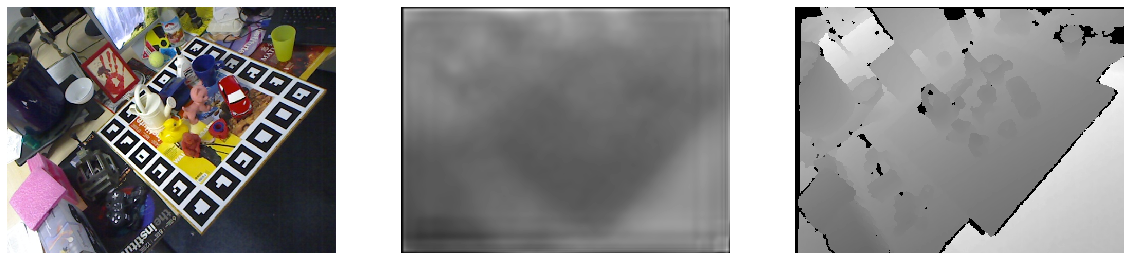

In [23]:
t = next(test_iter)
img, depth = t
img, depth = img.float().cuda(), depth.float().cuda()

model = 'trained_models/depth_prediction/pose_model_9_0.11616236608548287.pth'
estimator = DepthNet()
estimator.load_state_dict(torch.load(model))
estimator.cuda()
estimator.eval()

pred_log_depth = estimator(img).cpu().detach()[0]
pred_depth = torch.exp(pred_log_depth)

depth = depth.cpu()
max_d = torch.max(depth)
min_d = torch.min(depth)
depth_norm = (depth - min_d) * 255 / (max_d - min_d)

max_d = torch.max(pred_depth)
min_d = torch.min(pred_depth)
pred_depth_norm = (pred_depth - min_d) * 255 / (max_d - min_d)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
ax1.imshow(im_convert(img))
ax1.axis("off")
ax2.imshow(depth_to_img(pred_depth_norm), cmap='gray')
ax2.axis("off")
ax3.imshow(depth_to_img(depth_norm), cmap='gray')
ax3.axis("off")
